# Removing Moiré patterns from images

## Moiré patterns in Fourier spectrum

In [59]:
import numpy as np
from scipy.fftpack import *
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 150

Here we have two images: the original (cat_original.jpg) and a Moiré-degradated version of it (cat_horizontal.jpg). Let's load and see them:

In [60]:
orig = imageio.imread('images/cat_original.jpg')
noisy = imageio.imread('images/cat_horizontal.jpg')

To simplify the process, we are going to work with them in grayscale, so first we need to convert them:

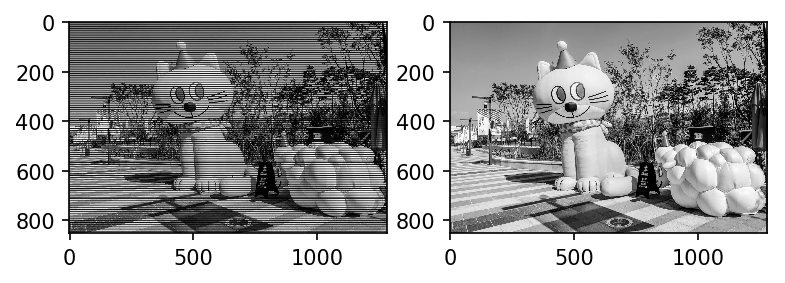

In [61]:
orig_gray = np.dot(orig[...,:3], [0.2989, 0.5870, 0.1140])
noisy_gray = np.dot(noisy[...,:3], [0.2989, 0.5870, 0.1140])

plt.subplot(121)
plt.imshow(noisy_gray, cmap='gray')
plt.subplot(122)
plt.imshow(orig_gray, cmap='gray')

Here's the Fourier spectrum for each of these images:

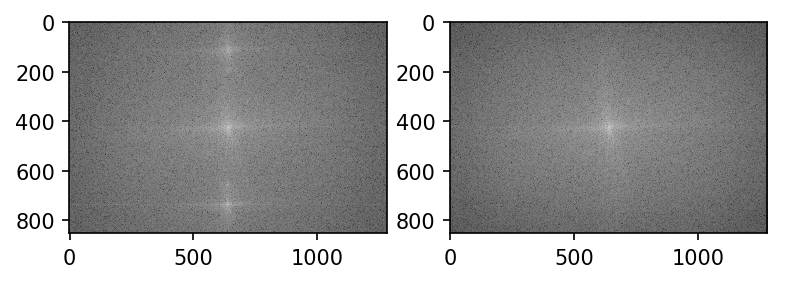

In [62]:
def compare_spectrums(noisy_gray, orig_gray):
    noisy_gray_fft = fft2(noisy_gray)
    orig_gray_fft = fft2(orig_gray)

    # Shift fft images
    orig_gray_fft_shift = fftshift(orig_gray_fft)
    noisy_gray_fft_shift = fftshift(noisy_gray_fft)

    plt.subplot(121)
    plt.imshow(np.abs(noisy_gray_fft_shift), cmap='gray', norm=LogNorm(vmin=5))
    plt.subplot(122)
    plt.imshow(np.abs(orig_gray_fft_shift), cmap='gray', norm=LogNorm(vmin=5))

compare_spectrums(noisy_gray, orig_gray)

Notice that, in the noisy image, two focuses appear in the vertical axis, this happens because the noise applied was horizontal and changes in the Fourier spectrum noises appear perpendicular to those in the image. Let's take a look at an image with diagonal Moiré patterns:

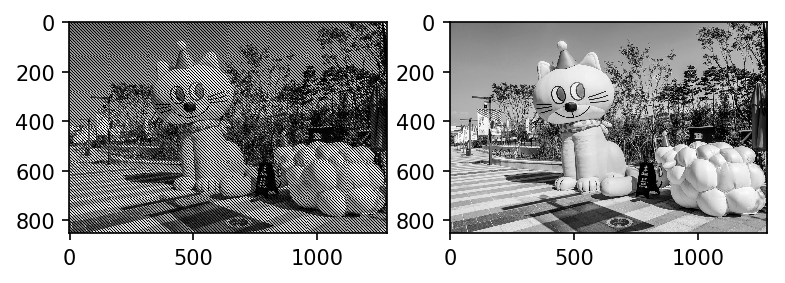

In [63]:
noisy_gray = imageio.imread('images/gray_cat_diagonal.jpg')

plt.subplot(121)
plt.imshow(noisy_gray, cmap='gray')
plt.subplot(122)
plt.imshow(orig_gray, cmap='gray')

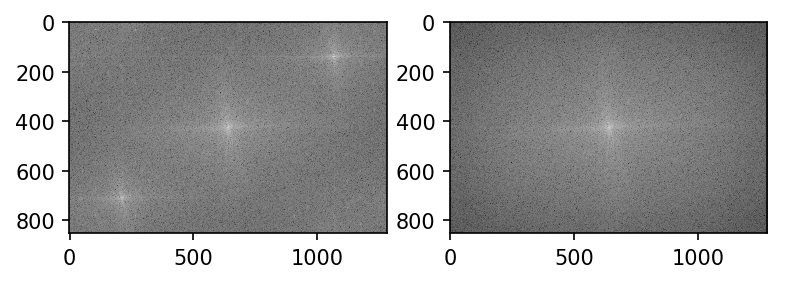

In [64]:
compare_spectrums(noisy_gray, orig_gray)

Note that the changes in the first image occur in the primary diagonal direction, but they appear in the secondary diagonal in the Fourier spectrum 

## First approach: low-pass filter

As the Moiré patterns seem to appear, in the Fourier spectrum, closer to the borders, while the real image features appear in the center of the spectrum, our first approach was to apply a low-pass filter in the image. The following function creates a low pass filter that can be applied to an image with shape `final_shape`

In [65]:

def _low_pass_filter(radius, final_shape, show_imgs=False):
    filt = np.zeros((radius, radius))

    # Create circle mask (pad later)
    for x in range(radius):
        for y in range(radius):
            if (radius//2 - x)**2 + (radius//2 - y)**2 < (radius//2)**2:
                filt[x][y] = 1

    if show_imgs:
        print(filt.shape)
        plt.imshow(filt, cmap='gray')
        plt.show()

    # Calculate padding shape (rows)
    aux1 = final_shape[0] - filt.shape[0]
    if(aux1 % 2 == 0): # even vs odd problem
        pad_cols = ( (final_shape[0] - filt.shape[0])//2, \
                    (final_shape[0] - filt.shape[0])//2)
    else:
        pad_rows = ( (final_shape[0] - filt.shape[0])//2+1, \
                     (final_shape[0] - filt.shape[0])//2+1 )

    # Calculate padding shape (cols)
    aux2 = final_shape[1] - filt.shape[1]
    if(aux2 % 2 == 0):
        pad_cols = ( (final_shape[1] - filt.shape[1])//2, \
                     (final_shape[1] - filt.shape[1])//2)
    else:
        pad_cols = ( (final_shape[1] - filt.shape[1])//2+1, \
                     (final_shape[1] - filt.shape[1])//2+1)

    pad_shape = (pad_rows, pad_cols)

    # Apply padding
    filt = np.pad(filt, pad_shape, 'constant', constant_values=0)
    if(aux1 % 2 != 0 and aux2 % 2 != 0):
        filt = filt[0:filt.shape[0]-1, 0:filt.shape[1]-1]
    elif(aux1 % 2 != 0 and aux2 % 2 == 0):
        filt = filt[0:filt.shape[0]-1, 0:filt.shape[1]]
    elif(aux1 % 2 == 0 and aux2 % 2 != 0):
        filt = filt[0:filt.shape[0], 0:filt.shape[1]-1]

    if show_imgs:
        print(filt.shape)
        plt.imshow(filt, cmap='gray')
        plt.show()

    return filt


Let's create a filter for the image with diagonal noise we saw above. The low pass filter is nothing but a matrix we multiply by the image in the Fourier spectrum. It has a circle of ones (1s) that don't modify the center of the spectrum, and the rest of the matrix has zeroes (0s) which cancel every other pixel to the borders of the image.

(501, 501)


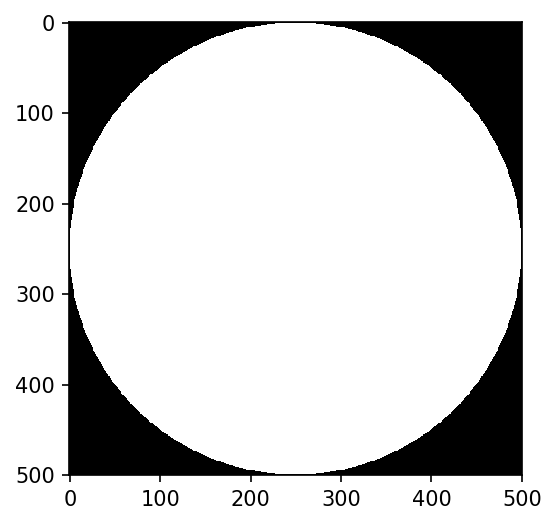

(854, 1280)


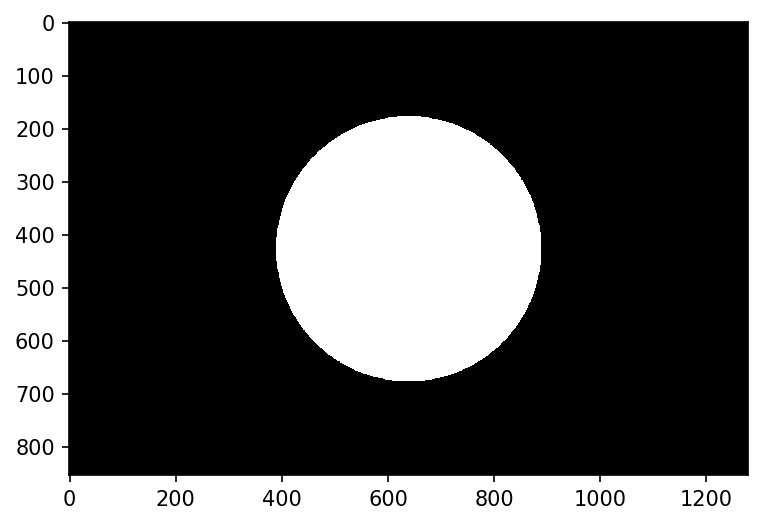

In [66]:
noisy_diag_filter = _low_pass_filter(501, noisy_gray.shape, show_imgs=True)

Now apply the filter to the noisy image in the Fourier spectrum. The following function uses the above function to create a low-pass mask, applies it to the noisy image and returns the restored image:

In [67]:

def low_pass(img, radius=501, show_imgs=False):
    """
    Filters image using low pass filter in Fourier domain
    Returns filtered image
    """

    img_fft = fftn(img)
    img_fft_shift = fftshift(img_fft)

    # Print spectrum before filtering
    if show_imgs:
        plt.imshow(np.abs(img_fft_shift), cmap='gray', norm=LogNorm(vmin=5))
        plt.show()

    filter_mask = _low_pass_filter(radius, img.shape)

    img_fft_shift_filtered = img_fft_shift * filter_mask

    # Print spectrum after filtering
    if show_imgs:
        plt.imshow(np.abs(img_fft_shift_filtered), cmap='gray', norm=LogNorm(vmin=5))
        plt.show()

    # Generate result image
    return ifftn(fftshift(img_fft_shift_filtered))


Let's use this function to restore `noisy_gray`:

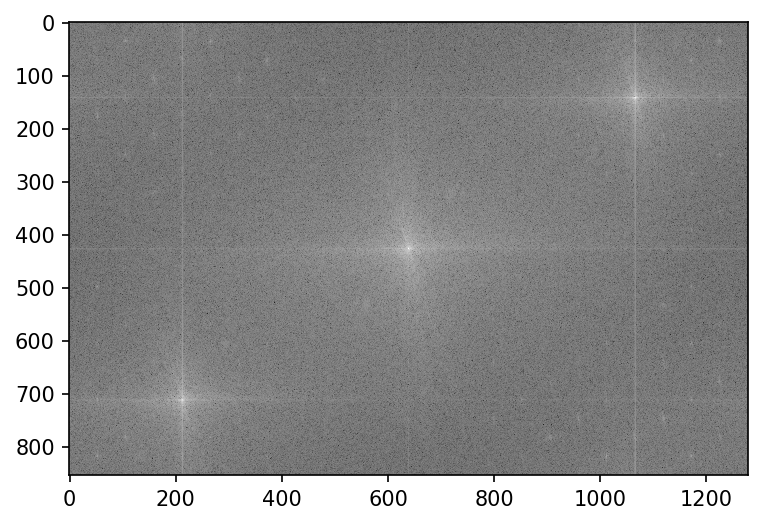

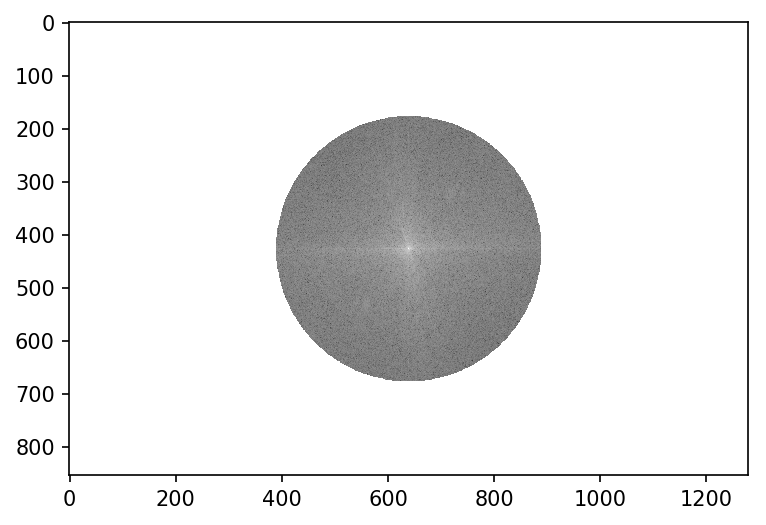

In [68]:
restored_gray = low_pass(noisy_gray, show_imgs=True)

Here's the image generated by the function compared to the noisy one:

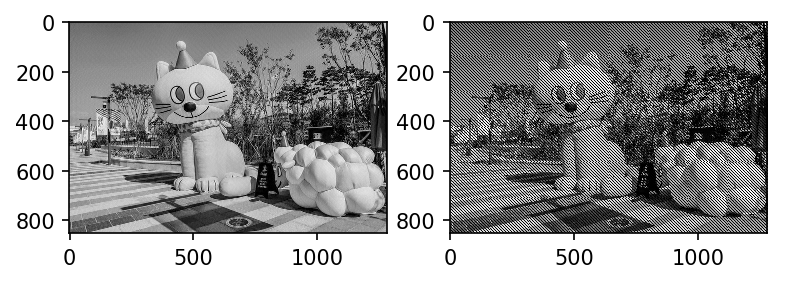

In [69]:
plt.subplot(121)
plt.imshow(np.abs(restored_gray), cmap='gray')
plt.subplot(122)
plt.imshow(noisy_gray, cmap='gray')


The problem with our low-pass filter, however, is that, for images with different orientations of Moiré patterns, it degrades too much the details

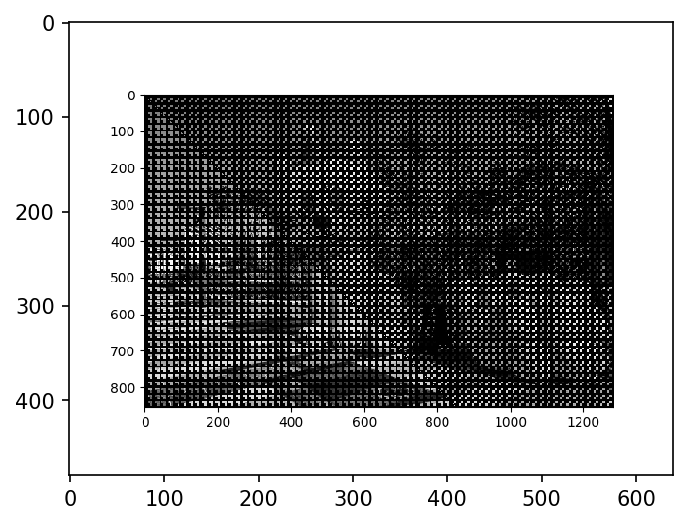

In [74]:
much_noisy = imageio.imread('images/cat_diag_horiz_vert.png')
much_noisy_gray = np.dot(much_noisy[...,:3], [0.2989, 0.5870, 0.1140])
plt.imshow(much_noisy_gray, cmap='gray')

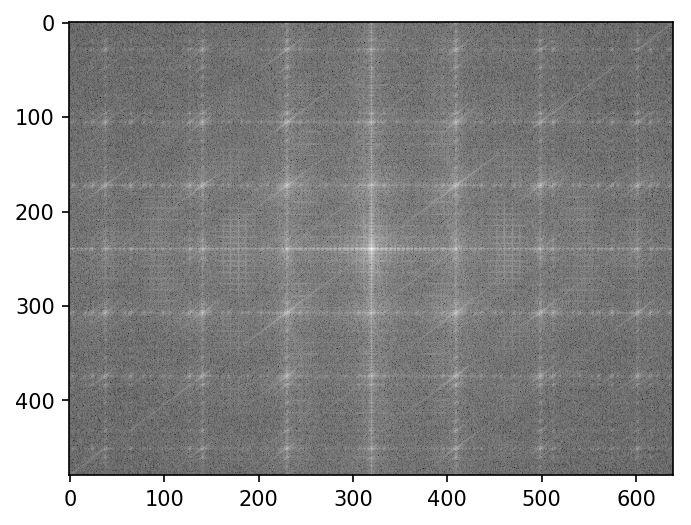

ValueError: index can't contain negative values

In [75]:
restored_much_noisy = low_pass(much_noisy_gray, show_imgs=True)

After applying the low pass filter, the degradation in the image is visible

# TODO:  APPLY FILTER AFTER FIXING CODE AND SHOW IMAGE

## Second approach: TODO: BLOCK SECONDARY CENTERS OF NOISE (NOT IMPLEMENTED YET)